# Ingest and View Data

In [1]:
import pandas as pd
from sqlalchemy import create_engine

In [2]:
POSTGRES_USERNAME = 'root'
POSTGRES_PASSWORD = 'koBREipm4h7CuRKix2Tn'
POSTGRES_HOSTNAME = 'database-1.c3ma8u2guxxs.us-east-2.rds.amazonaws.com'
POSTGRES_PORT = '5432'
POSTGRES_DBNAME = 'postgres'

connection_string = f"postgresql://{POSTGRES_USERNAME}:{POSTGRES_PASSWORD}@{POSTGRES_HOSTNAME}:{POSTGRES_PORT}/{POSTGRES_DBNAME}"
engine = create_engine(connection_string)

In [3]:
query = """
SELECT * FROM darwin
"""

df = pd.read_sql(query, engine)

In [4]:
df.head()

,route_id,unique_id,service_start_date,update_origin,train_platform,working_time_pass,working_time_arrival,working_time_departure,planned_time_arrival,planned_time_departure,...,platform,train_length,estimated_time,source,actual_time,actual_time_class,is_delayed_arrival,is_delayed_departure,source_instance,estimated_time_minutes
0,202407037139232,G39232,2024-07-03,TD,SCROYDN,None,19:31:00,19:31:30,19:31:00,19:31:00,...,4,10.0,None,None,None,None,False,False,None,None
1,202407036785172,C85172,2024-07-03,CIS,LIVSTLL,None,19:37:00,19:38:00,19:37:00,19:38:00,...,A,NaN,None,None,None,None,False,False,None,None
2,202407036735756,C35756,2024-07-03,TD,ESTHRAK,None,19:30:30,19:31:00,19:31:00,19:31:00,...,2,NaN,None,None,None,None,False,False,None,None
3,202407036735756,C35756,2024-07-03,TD,BRMB,None,19:33:00,19:33:30,19:33:00,19:33:00,...,1,NaN,None,None,None,None,False,False,None,None
4,202407036735756,C35756,2024-07-03,TD,BRMBRK,None,19:35:00,19:35:30,19:35:00,19:35:00,...,2,NaN,None,None,None,None,False,False,None,None


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65519 entries, 0 to 65518
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   route_id                65519 non-null  object 
 1   unique_id               65519 non-null  object 
 2   service_start_date      65519 non-null  object 
 3   update_origin           64303 non-null  object 
 4   train_platform          65519 non-null  object 
 5   working_time_pass       0 non-null      object 
 6   working_time_arrival    65519 non-null  object 
 7   working_time_departure  65519 non-null  object 
 8   planned_time_arrival    61183 non-null  object 
 9   planned_time_departure  61039 non-null  object 
 10  actual_arrival_time     57476 non-null  object 
 11  actual_departure_time   62171 non-null  object 
 12  platform                61744 non-null  object 
 13  train_length            19807 non-null  float64
 14  estimated_time          0 non-null    

# Clean DF 
**Drop Null Columns and Unnecessary Columns**

In [6]:
# columns to drop due to null values
columns_to_drop = [
    'working_time_pass',
    'estimated_time',
    'source',
    'actual_time',
    'actual_time_class',
    'source_instance',
    'estimated_time_minutes',
    'train_length'            
]

df_cleaned = df.drop(columns=columns_to_drop)

In [7]:
# check duplicates
duplicates = df_cleaned.duplicated().sum()
duplicates

3963

In [8]:
# to drop duplicates
# df_clean = df_clean.drop_duplicates()

In [9]:
# check nulls
df_cleaned.isna().sum()

route_id                     0
unique_id                    0
service_start_date           0
update_origin             1216
train_platform               0
working_time_arrival         0
working_time_departure       0
planned_time_arrival      4336
planned_time_departure    4480
actual_arrival_time       8043
actual_departure_time     3348
platform                  3775
is_delayed_arrival           0
is_delayed_departure         0
dtype: int64

In [10]:
# to drop remaining nulls
# df_cleaned = df_cleaned.dropna()

# Ingest Rail References Data

In [11]:
reference_df = pd.read_csv('./raw_data/RailReferences.csv')
reference_df.head()

,AtcoCode,TiplocCode,CrsCode,StationName,StationNameLang,GridType,Easting,Northing,CreationDateTime,ModificationDateTime,RevisionNumber,Modification
0,9100PENZNCE,PENZNCE,PNZ,Penzance Rail Station,NaN,U,147588,30599,2003-11-04T00:00:00,2011-09-30T14:47:28,2,rev
1,9100STIVES,STIVES,SIV,St Ives (Cornwall) Rail Station,NaN,U,151947,40127,2005-04-04T00:00:00,2011-09-30T14:47:28,4,rev
2,9100CARBISB,CARBISB,CBB,Carbis Bay Rail Station,NaN,U,152930,38745,2003-11-04T00:00:00,2011-09-30T14:47:28,5,rev
3,9100STERTH,STERTH,SER,St Erth Rail Station,NaN,U,154150,35730,2003-11-04T00:00:00,2007-02-13T17:06:21,3,rev
4,9100LELANTS,LELANTS,LTS,Lelant Saltings Rail Station,NaN,U,154430,36640,2003-11-04T00:00:00,2011-09-30T14:47:28,2,rev


## Convert Easting, Northing to Latitude and Longitude

In [12]:
!pip install pyproj

In [13]:
from pyproj import Transformer

In [14]:
#  Define the British National Grid projection (EPSG:27700) and WGS84
osgb_projection = 'epsg:27700'  # British National Grid
wgs84_projection = 'epsg:4326'  # WGS84

In [15]:
# Initialize the transformer
transformer = Transformer.from_crs(osgb_projection, wgs84_projection)

In [16]:
# Function to convert British National Grid to latitude and longitude
def convert_osgb_to_latlong(easting, northing):
    longitude, latitude = transformer.transform(easting, northing)
    return longitude, latitude

In [17]:
# Apply conversion to the DataFrame and create new columns Latitude and Longitude
reference_df[['Latitude', 'Longitude']] = reference_df.apply(lambda row: convert_osgb_to_latlong(row['Easting'], row['Northing']),\
                                         axis=1,\
                                         result_type='expand')

In [18]:
# Data need for analysis 
data = reference_df[['TiplocCode', 'StationName', 'Latitude', 'Longitude']]
data

,TiplocCode,StationName,Latitude,Longitude
0,PENZNCE,Penzance Rail Station,50.121672,-5.532565
1,STIVES,St Ives (Cornwall) Rail Station,50.209043,-5.477912
2,CARBISB,Carbis Bay Rail Station,50.197048,-5.463263
3,STERTH,St Erth Rail Station,50.170489,-5.444252
4,LELANTS,Lelant Saltings Rail Station,50.178775,-5.440926
...,...,...,...,...
2623,SMRLYTN,Somerleyton Rail Station,52.510229,1.652260
2624,OULTNBS,Oulton Broad South Rail Station,52.469602,1.707659
2625,YARMTH,Great Yarmouth Rail Station,52.612158,1.720886
2626,OULTNBN,Oulton Broad North Rail Station,52.477759,1.715711


### Data Enrichment
Used this section to add identifying information for top Timing Point Locations (*TiplocCode*) not already identified in the supplied "RailReferences.csv" data. 

Research indicates that the Timing Point Location for BONDST, correlates to Bond Street Station$^{1}$ located at 51.514°N, 0.15°W$^{2}$. 

In [19]:
new_row = pd.DataFrame([['BONDST', 'Bond Street Station', 51.514, -0.15]], columns=data.columns)
data = pd.concat([data, new_row], ignore_index=True)

In [20]:
data

,TiplocCode,StationName,Latitude,Longitude
0,PENZNCE,Penzance Rail Station,50.121672,-5.532565
1,STIVES,St Ives (Cornwall) Rail Station,50.209043,-5.477912
2,CARBISB,Carbis Bay Rail Station,50.197048,-5.463263
3,STERTH,St Erth Rail Station,50.170489,-5.444252
4,LELANTS,Lelant Saltings Rail Station,50.178775,-5.440926
...,...,...,...,...
2624,OULTNBS,Oulton Broad South Rail Station,52.469602,1.707659
2625,YARMTH,Great Yarmouth Rail Station,52.612158,1.720886
2626,OULTNBN,Oulton Broad North Rail Station,52.477759,1.715711
2627,LOWSTFT,Lowestoft Rail Station,52.474436,1.749708


### Bibliography

1. http://www.railwaycodes.org.uk/crs/crsb.shtm

2. https://en.wikipedia.org/wiki/Bond_Street_station

## Using Rail References to Replace Train Platform with Station Name

In [21]:
# Merge df_cleaned with data columns from reference_df

df_merged = df_cleaned.merge(data, left_on='train_platform', right_on='TiplocCode', how='left')

In [22]:
# check
df_merged.head()

,route_id,unique_id,service_start_date,update_origin,train_platform,working_time_arrival,working_time_departure,planned_time_arrival,planned_time_departure,actual_arrival_time,actual_departure_time,platform,is_delayed_arrival,is_delayed_departure,TiplocCode,StationName,Latitude,Longitude
0,202407037139232,G39232,2024-07-03,TD,SCROYDN,19:31:00,19:31:30,19:31:00,19:31:00,None,19:32:00,4,False,False,SCROYDN,South Croydon Rail Station,51.362963,-0.093457
1,202407036785172,C85172,2024-07-03,CIS,LIVSTLL,19:37:00,19:38:00,19:37:00,19:38:00,19:37:00,19:38:00,A,False,False,NaN,NaN,NaN,NaN
2,202407036735756,C35756,2024-07-03,TD,ESTHRAK,19:30:30,19:31:00,19:31:00,19:31:00,None,None,2,False,False,ESTHRAK,Eastham Rake Rail Station,53.307537,-2.981132
3,202407036735756,C35756,2024-07-03,TD,BRMB,19:33:00,19:33:30,19:33:00,19:33:00,19:33:00,19:33:00,1,False,False,BRMB,Bromborough Rail Station,53.321845,-2.986895
4,202407036735756,C35756,2024-07-03,TD,BRMBRK,19:35:00,19:35:30,19:35:00,19:35:00,19:35:00,19:35:00,2,False,False,BRMBRK,Bromborough Rake Rail Station,53.329905,-2.989469


In [23]:
# easier view
df_merged[['train_platform', 'TiplocCode', 'StationName']].head(10)

,train_platform,TiplocCode,StationName
0,SCROYDN,SCROYDN,South Croydon Rail Station
1,LIVSTLL,NaN,NaN
2,ESTHRAK,ESTHRAK,Eastham Rake Rail Station
3,BRMB,BRMB,Bromborough Rail Station
4,BRMBRK,BRMBRK,Bromborough Rake Rail Station
5,SPITAL,SPITAL,Spital Rail Station
6,PSLT,PSLT,Port Sunlight Rail Station
7,BEBNGTN,BEBNGTN,Bebington Rail Station
8,ROCKFRY,ROCKFRY,Rock Ferry Rail Station
9,RADYR,RADYR,Radyr Rail Station


In [24]:
# checking where train_platform has no related StationName/Tiploccode
nan_rows = df_merged[df_merged[['TiplocCode', 'StationName']].isna().any(axis=1)]

nan_rows[['train_platform', 'TiplocCode', 'StationName']]

,train_platform,TiplocCode,StationName
1,LIVSTLL,NaN,NaN
16,WOLWXR,NaN,NaN
23,FRMPKRS,NaN,NaN
24,HRNS451,NaN,NaN
25,BOWERRL,NaN,NaN
...,...,...,...
65257,WCHAPXR,NaN,NaN
65322,SKELTON,NaN,NaN
65382,TOTCTRD,NaN,NaN
65467,WORCPWY,NaN,NaN


In [25]:
# Identifying most highly frequented unknown Station Names
station_NaN = df_merged[df_merged['StationName'].isna()]['train_platform'].value_counts()
station_NaN.head(20)

train_platform
WCHAPXR    234
FRNDXR     232
LIVSTLL    231
TOTCTRD    222
PADTLL     129
CANWHRF    128
WOLWXR     121
CUSTMHS    121
MAGHNTH    101
BRENTX      84
STALBCS     80
LTCEADL     55
BOWERRL     49
LTCEREC     49
CNNBELL     48
CRKLREC     41
CLPHMYM     39
YORK656     37
MLLF        37
CRKLWRL     36
Name: count, dtype: int64

In [26]:
# fill NaN values in the StationName column with the corresponding train_platform values
df_merged['StationName'] = df_merged['StationName'].fillna(df_merged['train_platform'])

# Drop TiplocCode to avoid redundency
df_merged.drop(columns=['TiplocCode'], inplace=True)

# Replace 'Rail Station' with an empty string to make more readable
df_merged['StationName'] = df_merged['StationName'].str.replace(' Rail Station', '')

In [27]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65519 entries, 0 to 65518
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   route_id                65519 non-null  object 
 1   unique_id               65519 non-null  object 
 2   service_start_date      65519 non-null  object 
 3   update_origin           64303 non-null  object 
 4   train_platform          65519 non-null  object 
 5   working_time_arrival    65519 non-null  object 
 6   working_time_departure  65519 non-null  object 
 7   planned_time_arrival    61183 non-null  object 
 8   planned_time_departure  61039 non-null  object 
 9   actual_arrival_time     57476 non-null  object 
 10  actual_departure_time   62171 non-null  object 
 11  platform                61744 non-null  object 
 12  is_delayed_arrival      65519 non-null  bool   
 13  is_delayed_departure    65519 non-null  bool   
 14  StationName             65519 non-null

# Delays

In [28]:
# Create the 'delayed' column
df_merged['delayed'] = df_merged['is_delayed_arrival'] | df_merged['is_delayed_departure']

# Check
df_merged.head()

,route_id,unique_id,service_start_date,update_origin,train_platform,working_time_arrival,working_time_departure,planned_time_arrival,planned_time_departure,actual_arrival_time,actual_departure_time,platform,is_delayed_arrival,is_delayed_departure,StationName,Latitude,Longitude,delayed
0,202407037139232,G39232,2024-07-03,TD,SCROYDN,19:31:00,19:31:30,19:31:00,19:31:00,None,19:32:00,4,False,False,South Croydon,51.362963,-0.093457,False
1,202407036785172,C85172,2024-07-03,CIS,LIVSTLL,19:37:00,19:38:00,19:37:00,19:38:00,19:37:00,19:38:00,A,False,False,LIVSTLL,NaN,NaN,False
2,202407036735756,C35756,2024-07-03,TD,ESTHRAK,19:30:30,19:31:00,19:31:00,19:31:00,None,None,2,False,False,Eastham Rake,53.307537,-2.981132,False
3,202407036735756,C35756,2024-07-03,TD,BRMB,19:33:00,19:33:30,19:33:00,19:33:00,19:33:00,19:33:00,1,False,False,Bromborough,53.321845,-2.986895,False
4,202407036735756,C35756,2024-07-03,TD,BRMBRK,19:35:00,19:35:30,19:35:00,19:35:00,19:35:00,19:35:00,2,False,False,Bromborough Rake,53.329905,-2.989469,False


## Delays  by Route

In [29]:
# Calculate the count of delays for each route_id
delay_counts_by_route = df_merged.groupby('route_id')['delayed'].sum().reset_index()
delay_counts_by_route.rename(columns={'delayed': 'delay_counts_by_route'}, inplace=True)

# Calculate the total count of records for each route_id
total_counts_by_route = df_merged.groupby('route_id')['route_id'].count().reset_index(name='total_counts_by_route')

# Merge the delay counts and total counts
delay_summary = delay_counts_by_route.merge(total_counts_by_route, on='route_id')

# Calculate the % delayed for each route_id
delay_summary['%_delayed_by_route'] = (delay_summary['delay_counts_by_route'] / delay_summary['total_counts_by_route']) * 100

# Select the relevant columns
delays_by_route = delay_summary[['route_id', 'delay_counts_by_route', 'total_counts_by_route', '%_delayed_by_route']]

# Check
delays_by_route.head()

,route_id,delay_counts_by_route,total_counts_by_route,%_delayed_by_route
0,202407036704095,0,1,0.000000
1,202407036704542,0,1,0.000000
2,202407036705093,1,7,14.285714
3,202407036705096,0,13,0.000000
4,202407036705102,0,5,0.000000


In [40]:
# export delay routes csv
delays_route = delays_by_route.to_csv('./cleaned_data/delays_by_route.csv', index=False, mode = 'w+')

## Delays by Station Name

In [31]:
# Calculate the count of delays for each Station Name
delay_counts_by_station = df_merged.groupby('StationName')['delayed'].sum().reset_index()
delay_counts_by_station.rename(columns={'delayed': 'delay_counts_by_station'}, inplace=True)

# Calculate the total count of records for each route_id
total_counts_by_station = df_merged.groupby('StationName')['StationName'].count().reset_index(name='total_counts_by_station')

# Merge the delay counts and total counts
delay_summary_station = delay_counts_by_station.merge(total_counts_by_station, on='StationName')

# Calculate the % delayed for each route_id
delay_summary_station['%_delayed_by_station'] = (delay_summary_station['delay_counts_by_station'] / delay_summary_station['total_counts_by_station']) * 100

# Select the relevant columns
delays_by_station = delay_summary_station[['StationName', 'delay_counts_by_station', 'total_counts_by_station', '%_delayed_by_station']]

# Check
delays_by_station.head()

,StationName,delay_counts_by_station,total_counts_by_station,%_delayed_by_station
0,ABHLJN,8,23,34.782609
1,ABRD27,0,1,0.000000
2,ALSTONS,4,9,44.444444
3,ARBRUNS,0,2,0.000000
4,ARMLJCN,0,1,0.000000


In [41]:
# exporting delays by station to csv
delay_stations = delays_by_station.to_csv('./cleaned_data/delays_by_station.csv', index=False, mode = 'w+')

In [32]:
# check how is_delayed arrivals/departures compare with delayed column
df_merged['is_delayed_arrival'].value_counts()

is_delayed_arrival
False    60591
True      4928
Name: count, dtype: int64

In [33]:
df_merged['is_delayed_departure'].value_counts()

is_delayed_departure
False    60348
True      5171
Name: count, dtype: int64

In [34]:
df_merged['delayed'].value_counts()

delayed
False    60348
True      5171
Name: count, dtype: int64

Delayed column has same counts as is_delayed_departure. 

# Value Counts for Analysis 

In [35]:
df_merged['service_start_date'].value_counts()

service_start_date
2024-07-05    26206
2024-07-04    13486
2024-07-06    10258
2024-07-07     8225
2024-07-08     3672
2024-07-03     3610
2024-07-09       62
Name: count, dtype: int64

In [36]:
# most popular routes
df_merged['route_id'].value_counts()

route_id
202407047154179    141
202407046748489     96
202407047513588     92
202407057513588     91
202407076785195     84
                  ... 
202407058083631      1
202407058083366      1
202407056733069      1
202407057656865      1
202407087137127      1
Name: count, Length: 14387, dtype: int64

In [37]:
df_merged['train_platform'].value_counts()

train_platform
LNDNBDE    425
YORK       329
ECROYDN    246
BHAMNWS    244
WCHAPXR    234
          ... 
WNCBROJ      1
CDDRDPL      1
DLTNDPL      1
THRNTSJ      1
MEOLSCP      1
Name: count, Length: 2710, dtype: int64

# Visuals 

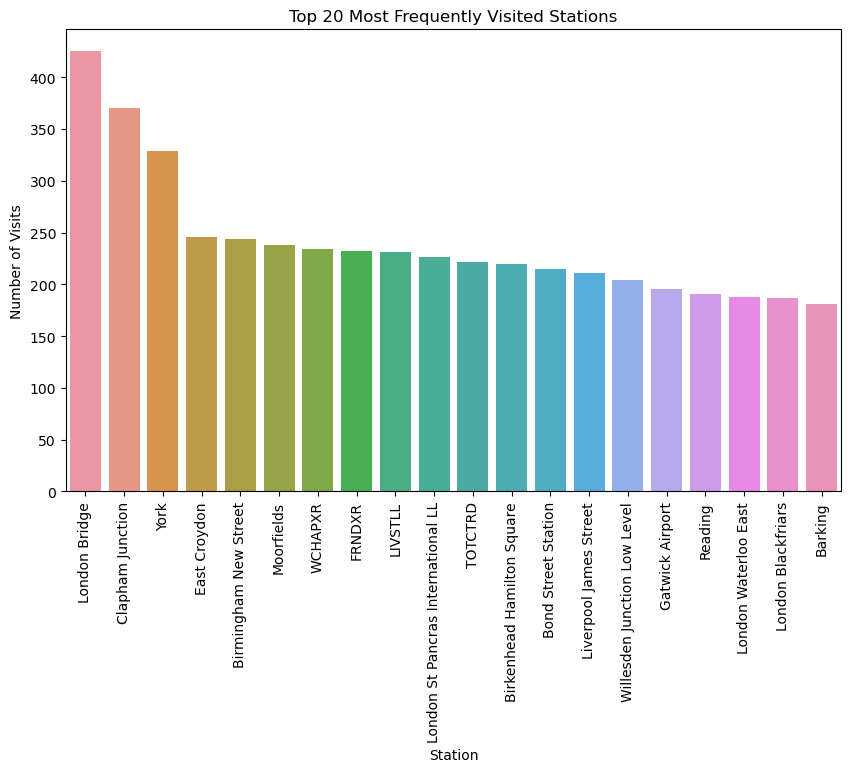

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
# Top 10 most frequently visited stations
top_stations = df_merged['StationName'].value_counts().head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_stations.index, y=top_stations.values)
plt.title('Top 20 Most Frequently Visited Stations')
plt.xlabel('Station')
plt.ylabel('Number of Visits')
plt.xticks(rotation=90)
plt.show()

# Export Desired Dataframe

In [39]:
output = df_merged.to_csv('./cleaned_data/UK_Rail_Data.csv', index=False, mode = 'w+')